In [1]:
!pip install pretty-confusion-matrix
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 281.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 747.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attempting uninstall: pyflakes
    Found existing installation: pyflakes 2.4.0
    Uninstalling pyflakes-2.4.0:
      Successfully uninstalled pyflakes-2.4.0
  Attempting uninstall: pycodestyle
    Found existing installation: pycodestyle 2.8.0
    Uninstalling pycodestyle-2.8.0:
      Successfully uninstalled pycodestyle-2.8.0
  Attempting uninstall: flake8
    Fo

In [2]:
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from keras.layers import Bidirectional, Input, Dense, Layer, Dropout, LSTM, Embedding, Flatten
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K

In [4]:
print(tf.__version__)

2.6.4


In [5]:
### HYPERPARAMETERS
POLITENESS_LEVELS = 5
EPOCHS = 30
MAXLEN = 768 # Since SciBERT returns 768 embeddings vector
LSTM_UNITS = 256
is_BiLSTM = True # Flag to automate other pre-processing for With or Without BiLSTM variants
VOCAB_LEN = 1853
EMBEDDING_DIMENSION = 768

## ADD PATH OF THE PRE-TRAINED MODEL HERE ##
SAVE_PATH = "./Ablation-Model.h5" 

In [6]:
### CHOOSE THE EMBEDDING VARIANT YOU WANT TO TRY ###

## SCI-BERT 
# name = 'SCIBERT'
# embed_model_name = 'gsarti/scibert-nli'

## TOXIC-BERT
# name = 'TOXIC-BERT'
# embed_model_name = 'troesy/toxicBERT_3epoch'

## HATE-BERT
# name = 'HATE-BERT'
# embed_model_name = 'GroNLP/hateBERT'

## Custom-Embedding
name = 'Custom-Embedding-BiLSTM'
embed_model_name=''

# LOAD DATASET

In [7]:
# LOAD EMBEDS DATASET

def loadPickle(name):
    start_path = '/kaggle/input/iitpolitenesslevels/'
    if is_BiLSTM:
        LOAD_PATH = start_path+'Tokennized_Processed_X_train-BiLSTM.csv'
        train_embeds = pd.read_csv(LOAD_PATH)
        
        LOAD_PATH = start_path+'Tokennized_Processed_X_test-BiLSTM.csv'
        test_embeds = pd.read_csv(LOAD_PATH)
        
        LOAD_PATH = start_path+'Tokennized_Processed_X_val-BiLSTM.csv'
        val_embeds = pd.read_csv(LOAD_PATH)
        
    else: 
        LOAD_PATH = start_path+name+'_train.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            train_embeds = pickle.load(handle)
            handle.close()

        LOAD_PATH = start_path+name+'_test.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            test_embeds = pickle.load(handle)
            handle.close()

        LOAD_PATH = start_path+name+'_val.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            val_embeds = pickle.load(handle)
            handle.close()

    y_train = pd.read_csv(start_path+'y_train.csv')
    y_val = pd.read_csv(start_path+'y_val.csv')
    y_test = pd.read_csv(start_path+'y_test.csv')

    print('\n***** LOADED '+ name+' *****\n')
    print(f'TRAIN SHAPE : {train_embeds.shape}\nTEST SHAPE : {test_embeds.shape}\nVAL SHAPE : {val_embeds.shape}\nY-TRAIN SHAPE : {y_train.shape}\nY-TEST SHAPE : {y_test.shape}\nY-VAL SHAPE : {y_val.shape}')

    return train_embeds, test_embeds, val_embeds, y_train, y_test, y_val

# /kaggle/input/iitpolitenesslevels/SCIBERT_train.pickle

In [8]:
train_embeds, test_embeds, val_embeds, y_train, y_test, y_val = loadPickle(name)


***** LOADED Custom-Embedding-BiLSTM *****

TRAIN SHAPE : (4556, 768)
TEST SHAPE : (855, 768)
VAL SHAPE : (284, 768)
Y-TRAIN SHAPE : (4556, 5)
Y-TEST SHAPE : (855, 5)
Y-VAL SHAPE : (284, 5)


### LOAD EMBEDDING MODEL

In [9]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [10]:
if not is_BiLSTM:
    tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
    embed_model = AutoModel.from_pretrained(embed_model_name)

In [11]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# SAMPLE SCIBERT
if not is_BiLSTM:
    sent = ['This work studies the predictive uncertainty issue of deep learning models.']
    outputs = sent2embed(embed_model, sent)
    outputs[1].shape


In [12]:
# PRE-PROCESS
def Embed(reviews, y_train, model):
    embed_arr = []
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(model, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])

    embed_train_arr = tf.stack(embed_arr)

    return embed_train_arr, y_train

# MODEL

### ATTENTION LAYER

In [13]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences , 
        })
        return config


    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a
        
        return K.sum(output, axis=1) 

In [14]:
if not is_BiLSTM:
    ## ONLY IF BiLSTM NOT there -- REDUCE DIMENSION OF DATASET BY 1DIM 
    train_embeds = np.array([row[0] for row in train_embeds ])
    test_embeds = np.array([row[0] for row in test_embeds ])
    val_embeds = np.array([row[0] for row in val_embeds ])


## DEFINE MODELS

### A) Custom Embedding with BiLSTM 

In [15]:
with open('/kaggle/input/iitpolitenesslevels/Embedding-Matrix.pickle', 'rb') as handle:
        Embedding_Matrix = pickle.load(handle)
        handle.close()

In [16]:
embed = Input(shape=  (MAXLEN, ), name='INPUT REVIEW') 
embedding_layer = Embedding(input_dim = VOCAB_LEN, output_dim = EMBEDDING_DIMENSION, 
                            weights=[Embedding_Matrix], input_length=MAXLEN, trainable=True, name='CUSTOM_EMBEDDING')(embed)
# print(embedding_layer.shape)
biLSTM = Bidirectional(LSTM(LSTM_UNITS ,dropout=0.2, return_sequences=False) , name='BILSTM' )(embedding_layer) 

flatten = Flatten()(biLSTM)
politeness_output = Dense(POLITENESS_LEVELS, activation='softmax', name='POLITENESS_OUTPUT')(flatten)

model = Model(inputs=embed, outputs=politeness_output)

2022-12-05 06:38:35.166477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 06:38:35.167603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 06:38:35.168271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 06:38:35.169132: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### B) SCIBERT/ TOXIC-BERT / HATE-BERT VARIANTS

In [17]:
# embed = Input(shape=  (MAXLEN,), name='INPUT') # without BiLSTM
# politeness_output = Dense(POLITENESS_LEVELS, activation='softmax', name='POLITENESS_OUTPUT')(embed)
# model = Model(inputs=embed, outputs=politeness_output)

## COMPILE MODEL

In [18]:
# metrics =[ 
#     'accuracy', 
#     tf.keras.metrics.Precision(), 
#     tf.keras.metrics.Recall()
# ]

model.compile(loss= 'categorical_crossentropy',
                        optimizer='adam', 
                        metrics=['accuracy']) 


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT REVIEW (InputLayer)    [(None, 768)]             0         
_________________________________________________________________
CUSTOM_EMBEDDING (Embedding) (None, 768, 768)          1423104   
_________________________________________________________________
BILSTM (Bidirectional)       (None, 512)               2099200   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
POLITENESS_OUTPUT (Dense)    (None, 5)                 2565      
Total params: 3,524,869
Trainable params: 3,524,869
Non-trainable params: 0
_________________________________________________________________


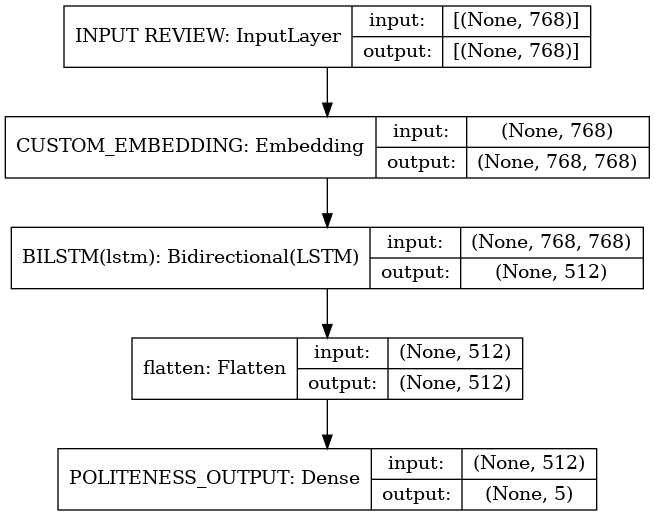

In [19]:
tf.keras.utils.plot_model(model, to_file='politeness_model.png', show_shapes=True)

## TRAIN MODEL

In [20]:
history = model.fit(train_embeds, 
                    y = y_train,  
                    validation_data = (test_embeds, y_test),
                    epochs = EPOCHS,
                   shuffle=True,
                   verbose=2
                )

2022-12-05 06:38:41.784825: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-05 06:38:45.027346: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


143/143 - 27s - loss: 1.4333 - accuracy: 0.3532 - val_loss: 1.0239 - val_accuracy: 0.5825
Epoch 2/30
143/143 - 22s - loss: 0.7321 - accuracy: 0.7155 - val_loss: 0.5843 - val_accuracy: 0.7836
Epoch 3/30
143/143 - 22s - loss: 0.4098 - accuracy: 0.8591 - val_loss: 0.5399 - val_accuracy: 0.8222
Epoch 4/30
143/143 - 22s - loss: 0.2550 - accuracy: 0.9102 - val_loss: 0.4976 - val_accuracy: 0.8409
Epoch 5/30
143/143 - 22s - loss: 0.1870 - accuracy: 0.9383 - val_loss: 0.4862 - val_accuracy: 0.8690
Epoch 6/30
143/143 - 22s - loss: 0.1234 - accuracy: 0.9622 - val_loss: 0.4802 - val_accuracy: 0.8854
Epoch 7/30
143/143 - 22s - loss: 0.1058 - accuracy: 0.9686 - val_loss: 0.5721 - val_accuracy: 0.8585
Epoch 8/30
143/143 - 22s - loss: 0.0761 - accuracy: 0.9776 - val_loss: 0.5377 - val_accuracy: 0.8912
Epoch 9/30
143/143 - 22s - loss: 0.0561 - accuracy: 0.9833 - val_loss: 0.5915 - val_accuracy: 0.8877
Epoch 10/30
143/143 - 22s - loss: 0.0638 - accuracy: 0.9811 - val_loss: 0.5566 - val_accuracy: 0.8854


In [21]:
# SAVE MODEL
SAVE_PATH = './Politeness_'+name+'.h5'
model.save(SAVE_PATH, overwrite=True, save_format="tf")
print("Weights Saved")

Weights Saved


In [22]:
# LOAD MODEL
from keras.models import load_model
LOAD_PATH = SAVE_PATH
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

model.evaluate(test_embeds, y_test)

MODEL LOADED


27/27 [==============================] - 2s 54ms/step - loss: 0.7185 - accuracy: 0.8936


[0.7185052037239075, 0.8935672640800476]

## ANALYSIS

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## VALIDATION

In [24]:
metrics_keys = list(history.history.keys())

loss = history.history[metrics_keys[0]]
accuracy = history.history[metrics_keys[1]]
val_loss = history.history[metrics_keys[2]]
val_accuracy = history.history[metrics_keys[3]]


print("\nACCURACY : " , accuracy)
print("\nLOSS : " , loss)
print("\nVAL LOSS : " , val_loss)
print("\nVAL ACCURACY : " , val_accuracy)


ACCURACY :  [0.35316067934036255, 0.7155399322509766, 0.8590869307518005, 0.9102282524108887, 0.9383230805397034, 0.9622476100921631, 0.968612790107727, 0.9776119589805603, 0.9833186864852905, 0.9811238050460815, 0.9795873761177063, 0.984196662902832, 0.9896839261054993, 0.988366961479187, 0.9910008907318115, 0.9912203550338745, 0.9925373196601868, 0.9910008907318115, 0.9852941036224365, 0.9888059496879578, 0.990342378616333, 0.990342378616333, 0.9896839261054993, 0.9892449378967285, 0.991878867149353, 0.991878867149353, 0.9925373196601868, 0.9931957721710205, 0.9931957721710205, 0.9934152960777283]

LOSS :  [1.4332853555679321, 0.7320571541786194, 0.40978625416755676, 0.25503993034362793, 0.18696653842926025, 0.12341233342885971, 0.10578051209449768, 0.07613687217235565, 0.05614547058939934, 0.06378644704818726, 0.05960989370942116, 0.048912353813648224, 0.036538250744342804, 0.029883570969104767, 0.0258674006909132, 0.028692545369267464, 0.023550603538751602, 0.02474891021847725, 0.

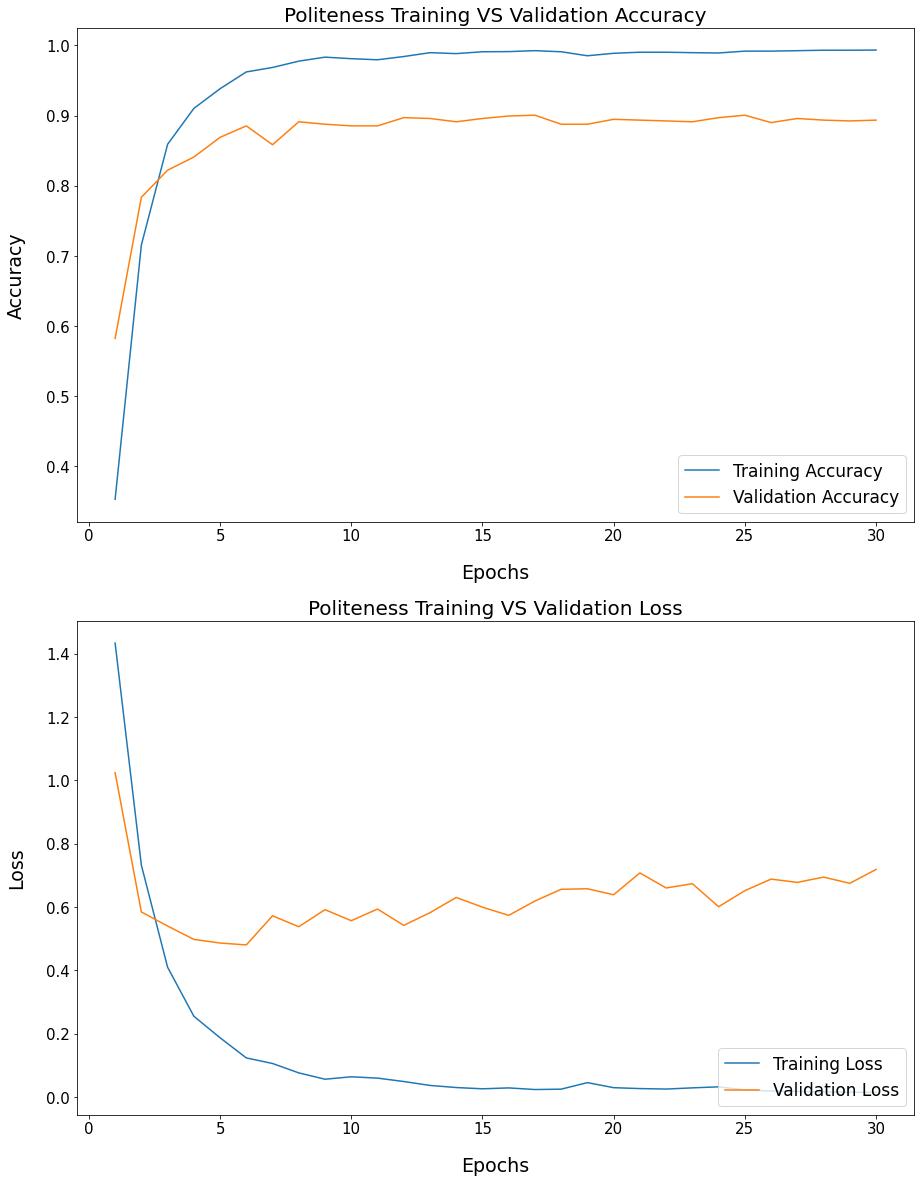

In [25]:
metrics = history.history['loss']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(15, 20))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Politeness Training VS Validation Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Politeness Training VS Validation Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Loss', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17, loc='lower right')

plt.show()

In [26]:
politeness = y_train.columns
politeness

Index(['HIMP', 'IMP', 'N', 'P', 'HP'], dtype='object')

In [27]:
# POLITENESS
y_pred_test = model.predict(test_embeds)
y_pred_val = model.predict(val_embeds)
y_pred_test_idx = np.argmax(y_pred_test, axis=1)
y_pred_val_idx = np.argmax(y_pred_val, axis=1)

y_test_true_idx =np.argmax(y_test.values, axis=1)
y_val_true_idx =np.argmax(y_val.values, axis=1)

In [28]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_test = cm(y_test_true_idx, y_pred_test_idx)
cm_val = cm(y_val_true_idx, y_pred_val_idx)

In [29]:
# CLASS-WISE ACCURACY
cm_test_acc = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
test_acc =cm_test_acc.diagonal()

# POLARITY ACCURACY
cm_val_acc = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
val_acc =cm_val_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE  TEST ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(politeness, test_acc):
    print('',cat,"\t",round(acc, 3))
    
# POLARITY
print('\n\n*** CLASS-WISE  VAL ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(politeness, val_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE  TEST ACCURACY : **** 

CLASS	ACCURACY
 HIMP 	 0.965
 IMP 	 0.877
 N 	 0.685
 P 	 0.931
 HP 	 1.0


*** CLASS-WISE  VAL ACCURACY : **** 

CLASS	ACCURACY
HIMP 	 0.961
IMP 	 0.824
N 	 0.678
P 	 0.885
HP 	 1.0


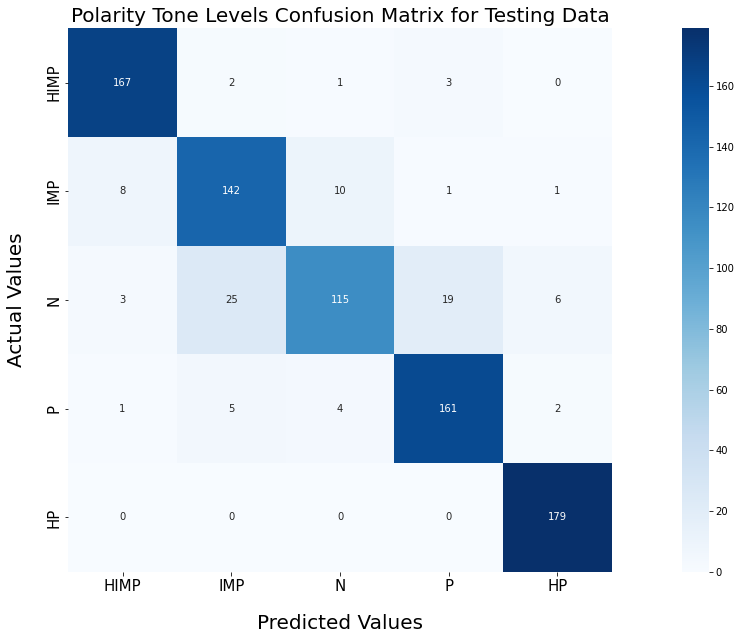

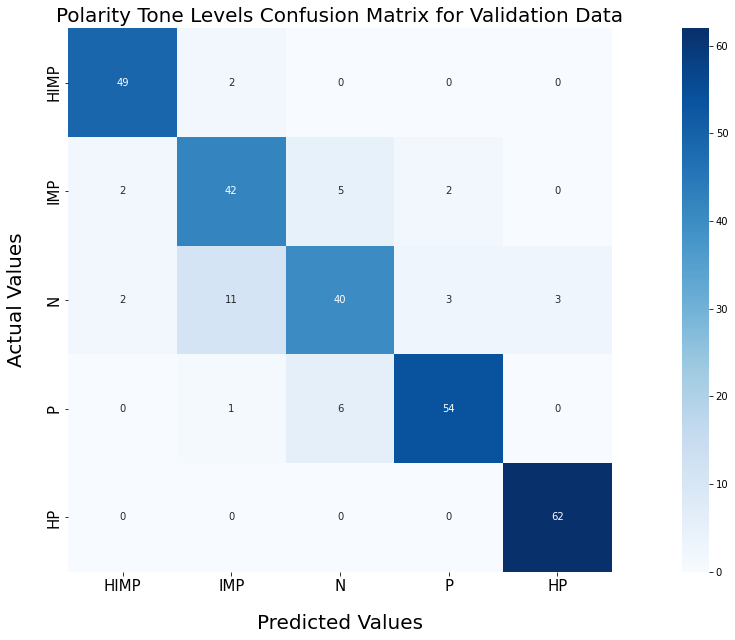

In [30]:
plt.figure(figsize=(25, 10))
sns.heatmap(cm_test, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=politeness, xticklabels=politeness)
plt.xlabel('Predicted Values', fontsize=20, labelpad=20)
plt.ylabel('Actual Values', fontsize=20, labelpad=20)
plt.title('Polarity Tone Levels Confusion Matrix for Testing Data', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()


plt.figure(figsize=(25, 10))
sns.heatmap(cm_val, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=politeness, xticklabels=politeness)
plt.xlabel('Predicted Values', fontsize=20, labelpad=20)
plt.ylabel('Actual Values', fontsize=20, labelpad=20)
plt.title('Polarity Tone Levels Confusion Matrix for Validation Data', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

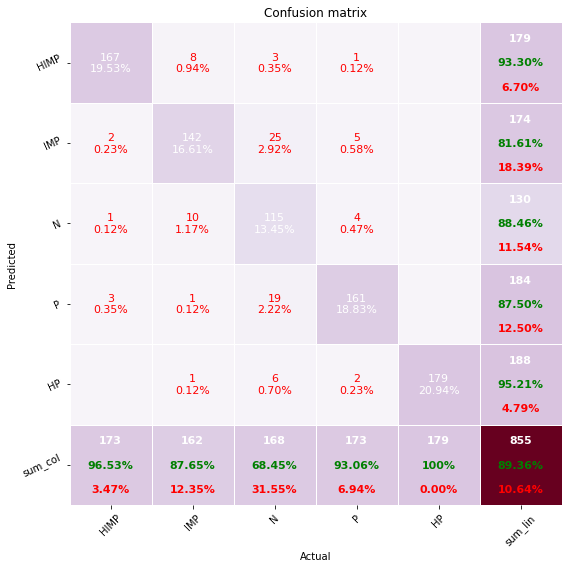

In [31]:
from pretty_confusion_matrix import pp_matrix

df_cm = pd.DataFrame(cm_test, index=politeness, columns=politeness)
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

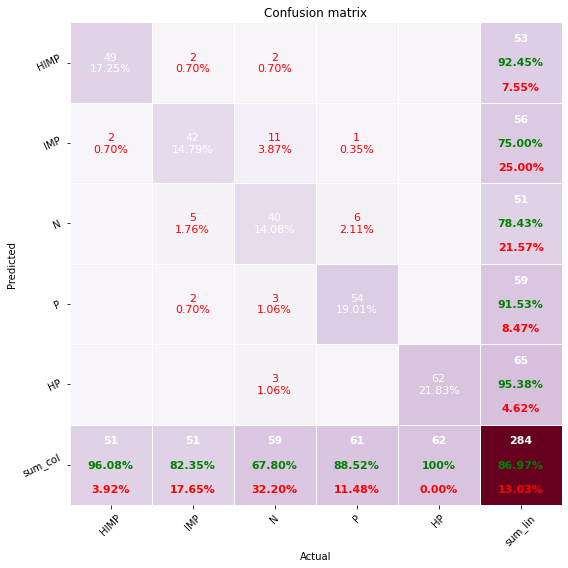

In [32]:
from pretty_confusion_matrix import pp_matrix

df_cm = pd.DataFrame(cm_val, index=politeness, columns=politeness)
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [33]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report

print(classification_report(y_test_true_idx, y_pred_test_idx, target_names=politeness))
print('\n\n',classification_report(y_val_true_idx, y_pred_val_idx , target_names=politeness))

              precision    recall  f1-score   support

        HIMP       0.93      0.97      0.95       173
         IMP       0.82      0.88      0.85       162
           N       0.88      0.68      0.77       168
           P       0.88      0.93      0.90       173
          HP       0.95      1.00      0.98       179

    accuracy                           0.89       855
   macro avg       0.89      0.89      0.89       855
weighted avg       0.89      0.89      0.89       855



               precision    recall  f1-score   support

        HIMP       0.92      0.96      0.94        51
         IMP       0.75      0.82      0.79        51
           N       0.78      0.68      0.73        59
           P       0.92      0.89      0.90        61
          HP       0.95      1.00      0.98        62

    accuracy                           0.87       284
   macro avg       0.87      0.87      0.87       284
weighted avg       0.87      0.87      0.87       284



# INFERENCE MODEL

In [34]:
# def predictPreprocess(model, sent):
#     outputs = sent2embed(model, sent)
#     pred_X = np.array([outputs[1].detach().numpy()[0]])
#     embed_X = tf.stack(pred_X)
#     return embed_X

In [35]:
# def inferenceModel(model, embed_model, sent):
#     labels = y_train.columns
#     sents= sent.split('.')[:-1]
#     results =[]
#     for s in sents:
#         sample_embed = predictPreprocess(embed_model, s.strip())
#         politness_probab = model.predict(sample_embed)
#         politness_label_idx = np.argmax(politness_probab[0])
#         results.append([labels[politness_label_idx] ])
        
#     return results

In [36]:
# # SAMPLE 1
# sent = '''This paper presents a model-free policy gradient approach for 
# reinforcement learning that combines on-policy  updates with an off-policy 
# critic . The hope is to learn continuous control in a sample-efficient fashion. 
# The approach  is validated on a number of low-dimensional continuous control 
# tasks in a simulated environment.'''
# op = inferenceModel(model,embed_model, sent)

# print('PREDICTED OUTPUT :', op)

In [37]:
# # SAMPLE 2
# sent = '''However , since the processing of sequential data seems to be a broad and general area of application , it is  
# conceivable that this work will be useful in the design and application of 
# future CNNs . All in all , this paper introduces  an interesting idea to 
# address an important topic .'''
# op = inferenceModel(model,embed_model, sent)

# print('PREDICTED OUTPUT :', op)